In [1]:
#!pip install pynhd pygeohydro py3dep


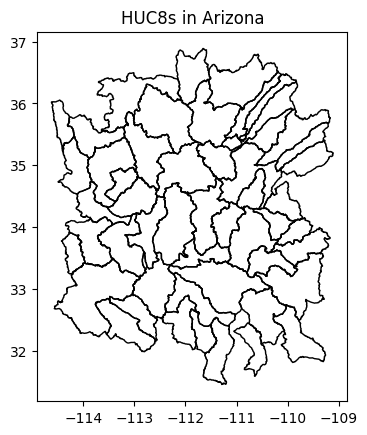

In [2]:
# Step 1: Get the HUC8 Boundaries for Arizona
from pygeohydro import WBD

wbd = WBD("huc8")

az_huc8 = wbd.byids("states", ["AZ"])

import matplotlib.pyplot as plt
ax = az_huc8.plot(edgecolor="black", facecolor="none")
ax.set_title("HUC8s in Arizona")
plt.show()


In [3]:
print(az_huc8.columns)


Index(['geometry', 'objectid', 'tnmid', 'metasourceid', 'sourcedatadesc',
       'sourceoriginator', 'sourcefeatureid', 'loaddate', 'referencegnis_ids',
       'areaacres', 'areasqkm', 'states', 'huc8', 'name', 'globalid',
       'shape_Length', 'shape_Area'],
      dtype='object')


In [ ]:
from pynhd import NHD
import geopandas as gpd
import pandas as pd
from tqdm import tqdm

nhd = NHD("flowline_hr")

all_flowlines = []
failed_hucs = []
empty_hucs = []

for idx, huc in tqdm(az_huc8.iterrows(), total=az_huc8.shape[0], desc="Processing HUC8s"):
    huc_id = huc.huc8  # easier to read and consistent

    try:
        # Query flowlines for this HUC8
        fl = nhd.bygeom(huc.geometry)

        # If flowlines were returned and FTYPE column exists, filter
        if not fl.empty and "FTYPE" in fl.columns:
            fl = fl[fl.FTYPE != "Coastline"]
            all_flowlines.append(fl)
            print(f"HUC8 {huc_id} — {len(fl)} flowlines retrieved")
        elif fl.empty:
            empty_hucs.append(huc_id)
            print(f"HUC8 {huc_id} — No flowlines found")
        else:
            print(f"HUC8 {huc_id} — Flowlines retrieved but FTYPE column missing")
            all_flowlines.append(fl)  # Still add what was found

    except Exception as e:
        print(f"Failed for HUC8 {huc_id}: {e}")
        failed_hucs.append(huc_id)

# Combine all successful flowlines
if all_flowlines:
    flowlines = gpd.GeoDataFrame(pd.concat(all_flowlines, ignore_index=True), crs=az_huc8.crs)
    print(f"\n✅ Total flowlines collected: {len(flowlines)}")
else:
    flowlines = gpd.GeoDataFrame(columns=["geometry"])
    print("\n⚠ No flowlines found for any HUC8s.")

# Summary report
print("\nSummary:")
print(f"Total successful HUC8s: {len(all_flowlines)}")
print(f"HUC8s with no flowlines: {len(empty_hucs)}")
print(f"HUC8s failed due to errors/timeouts: {len(failed_hucs)}")

if failed_hucs:
    print("\n⚠ Failed HUC8s:")
    print(failed_hucs)


Processing HUC8s:   2%|▏         | 1/51 [00:01<00:52,  1.05s/it]

HUC8 15010002 — Flowlines retrieved but FTYPE column missing


Processing HUC8s:   4%|▍         | 2/51 [00:01<00:45,  1.09it/s]

HUC8 15010004 — Flowlines retrieved but FTYPE column missing


Processing HUC8s:   8%|▊         | 4/51 [00:02<00:22,  2.10it/s]

HUC8 15010007 — Flowlines retrieved but FTYPE column missing
HUC8 15010014 — Flowlines retrieved but FTYPE column missing


Processing HUC8s:  10%|▉         | 5/51 [00:03<00:24,  1.88it/s]

HUC8 15020005 — Flowlines retrieved but FTYPE column missing


Processing HUC8s:  12%|█▏        | 6/51 [00:16<03:43,  4.97s/it]

HUC8 15020007 — Flowlines retrieved but FTYPE column missing


Processing HUC8s:  14%|█▎        | 7/51 [00:17<02:41,  3.66s/it]